<a href="https://colab.research.google.com/github/lln-cid20/prog-ciencia-dados/blob/master/TrabalhoConjunto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Apresentação**

**Resumo**

Este trabalho, realizado como atividade final da disciplina de Programação para Ciência de Dados, do curso de Pós-graduação em Ciência de Dados 2020/2021, apresenta os resultados da análise sobre uma base de dados de tweets, procurando identificar as diversas perguntas feitas em relação à COVID-19, bem como classificar as perguntas conforme os tipos a seguir: sintomas, tratamento, entidades e pessoas.

**Autores**
*   Lelson Lopes Nascimento
*   Levi Delmiro De Souza Bessa





# 1 Visão Geral dos Dados

Aqui são carregadas as bibliotecas básicas usadas no projeto



In [ ]:
!pip install spacy --upgrade
!python -m spacy download pt
#!python -m spacy download en

import pandas as pd
import numpy as np
import spacy
import string
import re
import os.path

import nltk 
nltk.download('stopwords')
nltk.download('punkt')

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/Shared drives/modulo02/dados-curso-completo.csv')
data.head(3)

     |████████████████████████████████| 10.0MB 2.6MB/s 
     |████████████████████████████████| 2.1MB 37.4MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 19.6MB 3.7MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.3.0-cp36-none-any.whl size=19557499 sha256=f30fbb57ed5de50d2588abc3cedea140afcf7a4c52a72f1a3ecc250c50dddd15
  Stored in directory: /tmp/pip-ephem-wheel-cache-chnf40ub/wheels/f6/43/f6/949b5e2b48df37aa3ed81fc3f4af4154afa276518cc004b990
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/pt
You can now load the model via spa

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado??? Congres...,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
1,2020-03-18 03:18:14,Seu Zé da Farmácia,seuzedafarmacia,"Em ação preventiva, o Governo do Estado suspen...",0,56,pt,NaN,NaN,NaN,NaN,NaN,[]
2,2020-03-29 12:09:27,Marília Oliveira 🇧🇷,Marioliveira_gb,Incrível como os defensores do fim do distanci...,0,5,pt,NaN,NaN,NaN,NaN,NaN,[]




> A base de dados contém 16.588.25 sentenças com 13 atributos respectivamente.







## 1.1 Frequência dos Idiomas
* Quantidade e porcentagem do total de idiomas identificados nos Tweets

In [ ]:
frequency_languages = data['idioma'].value_counts()
frequency_languages = frequency_languages.to_frame()

percents_of_freq = []
for i in frequency_languages['idioma']:
    percents_of_freq.append(round(float((i/data.shape[0])*100),4))
    
frequency_languages['porcentagem'] = percents_of_freq
frequency_languages.columns = ['quantidade','porcentagem']
frequency_languages.head()

,quantidade,porcentagem
pt,1586796,95.6578
en,23991,1.4463
es,14255,0.8593
it,6480,0.3906
und,5656,0.3410


##  1.2 Evolução do número de tweets 

In [ ]:
# Criação de uma coluna para agrupar tweets de forma diária
data['data_inversa'] = pd.to_datetime(data['data'],yearfirst=True, format='%Y-%m-%d')
# Agrupar os dados com base na nova coluna, criando um dataframe com os dados agrupados
dados_sumario = data['data_inversa'].groupby(data['data_inversa'].dt.to_period('D')).agg('count').to_frame()
data = data.drop(columns=['data_inversa'])
# Criar coluna para contagem de tweets
# dados_sumario.columns = [cont_tweets']
# Mostrar os primeiros registros do dataframe de valores agregados por dia
dados_sumario.head(5)

,data_inversa
data_inversa,
2020-01-01,28
2020-01-02,70
2020-01-03,71
2020-01-04,79
2020-01-05,69


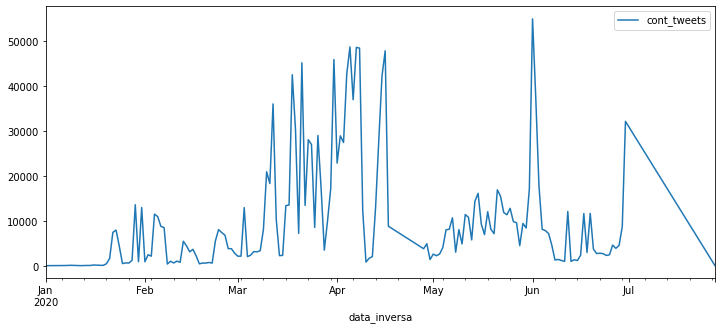

In [ ]:
dados_sumario.plot(figsize=(12,5))

In [ ]:
data.head(2)

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado??? Congres...,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
1,2020-03-18 03:18:14,Seu Zé da Farmácia,seuzedafarmacia,"Em ação preventiva, o Governo do Estado suspen...",0,56,pt,NaN,NaN,NaN,NaN,NaN,[]


## 1.3 Rank de quantidade de Tweets por Cidade

* Selecionar as 10 primeiras cidades para exibição em um gráfico (dos tweets que possuiam essa informacao de local)

In [ ]:
dados_cidades = data['lugar'].groupby(data['lugar']).agg('count').to_frame()
dados_cidades.columns = ['cont_tweets']

dados_cidades = dados_cidades.sort_values(['cont_tweets','lugar'], ascending=False)

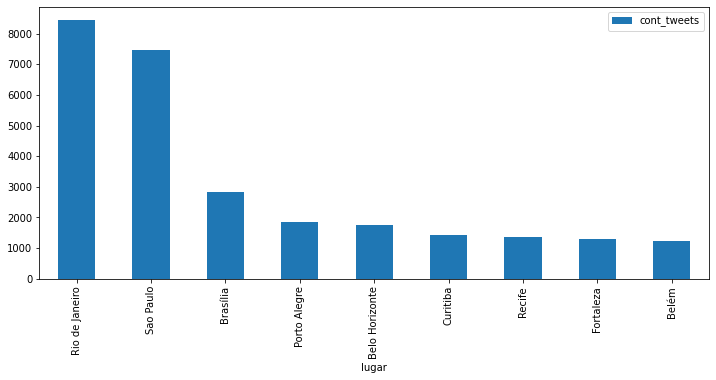

In [ ]:
dados_cidades = dados_cidades[0:9]
dados_cidades.plot(kind= 'bar',figsize=(12,5))

## 1.4 Frequência dos Tweets por horas

In [ ]:
df= data.copy()
df.index =  pd.to_datetime(df.data)
df = df.drop('data',axis=1)
df = df.sort_values(['data'])
hours = pd.Series(df.index.hour)
hours = pd.Series(hours.value_counts()).sort_index()

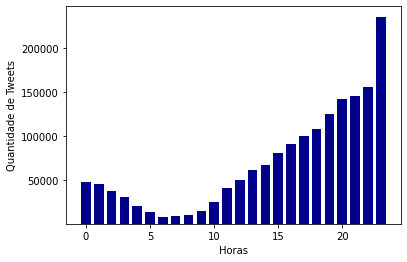

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, ax = plt.subplots()
x = np.arange(len(hours))
y = np.array(hours)

dim = 1
w = 0.75
dimw = w / dim

for i in range(0,24):
  ax.bar(i,y[i],dimw,bottom=0.001,align='center',color='#00008B')
  
ax.set_xlabel('Horas')
ax.set_ylabel('Quantidade de Tweets')

plt.show()

## 1.5 Retweet por usuários que possuem maior numero de seguidores



> A relação do usuário com maior numero de seguidores e o usuário com maior numero de retweets não está coerente, seria efeito do bot ?



In [ ]:
# Ranking dos usuários com maior numero de seguidores
rank = data.iloc[:,[1,4,5]]
rank = rank.groupby('usuario').agg(
    max_seguidores = pd.NamedAgg(column='seguidores',aggfunc=max),
    total_retweet = pd.NamedAgg(column='retweet',aggfunc=sum)
)
rank = rank.sort_values(by='max_seguidores',ascending=False)
#ranking dos usuarios com maior numero de retweets
rank2 = rank.sort_values(by='total_retweet',ascending=False)

In [ ]:
print(rank[0:5])
print(rank2[0:5])

                 max_seguidores  total_retweet
usuario                                       
Donald J. Trump        84241250          21369
Reuters                22098307             46
CNN en Español         18878720            161
Danilo Gentili         17244348           1936
Whindersson 🏠          16969481          16886
                    max_seguidores  total_retweet
usuario                                          
Maryy                          218        1139763
My cabbages!!                  737         989485
Tr1gger Mike                    43         901093
🌹                             2513         887268
tweets not loading             765         850226


## 1.6 Total de Hashtags nas cidades mais frequentes

In [ ]:
#1 = usuario | 7 = lugar | 12 = hashtags
rank = data.iloc[:,[1,7,12]]
rank.head(2)

# rank = rank.groupby('lugar').agg(
#     totalHashtags = pd.NamedAgg(column='hashtags',aggfunc=count)#,
#     #total_retweet = pd.NamedAgg(column='hashtags',aggfunc=sum)
# )
# rank #= rank.sort_values(by='max_seguidores',ascending=False)

test = rank.groupby(['lugar', 'usuario'])['hashtags'].count()
frame = pd.DataFrame(test)
frame = frame.sort_values('hashtags',ascending=False,ignore_index=False)
frame = frame.reset_index(level=[0])

frame[0:10]

,lugar,hashtags
usuario,,
TSF Rádio,Lisbon,338
Felipe 🅱️,Rio de Janeiro,205
Monster3366,Sao Paulo,156
Guto Menna-Barreto (em 🏚) 🏳️‍🌈,Curitiba,139
Ana Helena Mofatto 🇧🇷👊💚,Limeira,114
💙💛💚Débora.B.P.💚💛💙,Sao Paulo,96
Nelson Carvalheira,Rio de Janeiro,95
Lr1 | O Liberal Regional,Araçatuba,95
Emerson Damasceno,Fortaleza,82


In [ ]:
popular_tweet_city = ['Rio de Janeiro','Sao Paulo','Brasília','Porto Alegre','Belo Horizonte']
total_hastags = []

for city in popular_tweet_city:
  uf = frame.loc[frame['lugar'] == city]
  uf = np.sum(uf['hashtags'])
  total_hastags.append(uf)

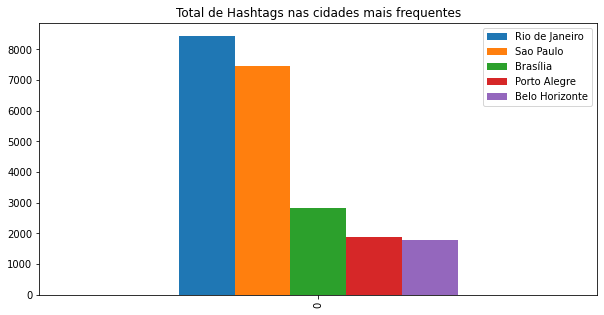

In [ ]:
show = pd.DataFrame([total_hastags], columns=popular_tweet_city)
show.plot(kind= 'bar',figsize=(10,5),title='Total de Hashtags nas cidades mais frequentes')

# 2 Temas Discutidos

*   Identificar os Tweets que contenham perguntas ('?')
*   Após separar cada Tweet em sentenças, mantém-se apenas a setença que contenha '?'
  *  Remove os Links que foram identificados como possiveis perguntas (talvez contenham '?')
*   Remoção de StopWords



## 2.1 Gerar duvidasDB


Criação da base de dados com tweets que tem perguntas ou seja, as que possuem um sinal de interrogação

In [ ]:
registros_com_duvidas = data.loc[data.texto.str.find('?') >= 0 ]

Importação de bibliotecas para processamento de linguagem natural para tratamento dos textos dos tweets

In [ ]:
# pip install nltk

import nltk

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
# from nltk import sent_tokenize

from nltk.corpus import stopwords
from string import punctuation

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('mac_morpho')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package mac_morpho to /root/nltk_data...
[nltk_data]   Unzipping corpora/mac_morpho.zip.


True

Gerar a base de dados de dúvidas com as perguntas

In [ ]:
import os.path
# if que verifica se já existe arquivo de dúvida. Se não existir o arquivo é criado
if not os.path.exists('/content/drive/Shared drives/modulo02/duvidasDB.csv'):
    # Criando novo DataFrame
    duvidasDB = pd.DataFrame()

    #Fazendo a iteração:

    for index, row in registros_com_duvidas.iterrows():
        # extrai o texto contendo a pergunta
        texto = registros_com_duvidas.loc[index,'texto']

        # separa as sentenças e as palavras
        sentencas = sent_tokenize(texto)

        # seleciona as stopwords (palavras que não trazem informação relevante) e os sinais de pontuação
        sentencas_perguntas = [sentenca for sentenca in sentencas if sentenca.find('?') >= 0]
        sentencas_perguntas = [sentenca for sentenca in sentencas_perguntas if not sentenca == '?']

        # para cada pergunta será gerada uma linha na Base DúvidasDB, com todos atributos necessários para análise
        for i in sentencas_perguntas:
 
           df3 = pd.DataFrame( {'data': [registros_com_duvidas.loc[index,'data']], 'retweet': [registros_com_duvidas.loc[index,'retweet']], 'seguidores':[registros_com_duvidas.loc[index,'seguidores']], 
                                 'idioma':[registros_com_duvidas.loc[index,'idioma']], 'lugar':[registros_com_duvidas.loc[index,'lugar']],  'pais':[registros_com_duvidas.loc[index,'pais']],
                                 'sigla':[registros_com_duvidas.loc[index,'sigla']], 'latitude':[dadosregistros_com_duvidas2.loc[index,'latitude']],  'longitude':[registros_com_duvidas.loc[index,'longitude']],
                                 'pergunta': [i]  , 'id_origem': [index] })
           duvidasDB = duvidasDB.append(df3)

    # A base de dados é gravada em 'DuvidasDB'
    duvidasDB.to_csv('/content/drive/Shared drives/modulo02/duvidasDB.csv')

# se existir, o arquivo é lido
else:
   duvidasDB = pd.read_csv('/content/drive/Shared drives/modulo02/duvidasDB.csv')
# Fim do if

Exibição das primeiras linhas da base de perguntas

In [ ]:
print(duvidasDB.shape)
duvidasDB.head(8)


(198258, 12)


,Unnamed: 0,data,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,pergunta,id_origem
0,0,2020-03-23 18:51:14,0,138,pt,NaN,NaN,NaN,NaN,NaN,@BolsonaroSP Cade o fundão deputado???,0
1,0,2020-04-01 21:11:07,0,1885,pt,NaN,NaN,NaN,NaN,NaN,Fumaça de cigarro pode propagar coronavírus?,3
2,0,2020-06-25 11:09:19,0,86,pt,NaN,NaN,NaN,NaN,NaN,@ipratesMD @dr_pampers Será que corremos o ris...,38
3,0,2020-04-06 15:44:36,0,219,pt,NaN,NaN,NaN,NaN,NaN,Prioridade ?!,45
4,0,2020-03-30 00:43:36,0,201,pt,NaN,NaN,NaN,NaN,NaN,"Que tal uma notícia boa, indo na contramão do ...",57
5,0,2020-04-07 23:19:44,0,23,pt,NaN,NaN,NaN,NaN,NaN,@JoseMedeirosMT Seria isso algum tipo aleatóri...,73
6,0,2020-04-13 19:16:51,3,253,pt,Santos,Brazil,BR,NaN,NaN,"""Nova York é o novo epicentro da pandemia de c...",77
7,0,2020-05-15 18:15:33,0,67,pt,NaN,NaN,NaN,NaN,NaN,@mitags Será por que o Bolsonaro não fez propa...,116


Exibição do contador da base de parguntas

In [ ]:
dt = duvidasDB['idioma'].groupby(duvidasDB['idioma']).agg('count').sort_values(ascending=False)
dt

idioma
pt     192547
en       2113
es       1221
it        893
fr        467
ca        380
tr        100
in         94
ko         73
und        62
ru         47
tl         41
hi         34
de         33
pl         32
nl         20
th         16
ht         10
iw          8
uk          7
et          7
ja          6
eu          6
sv          6
cs          5
el          4
lt          4
sr          3
da          2
zh          2
fi          2
vi          2
te          2
am          2
hu          1
is          1
ro          1
ta          1
cy          1
ur          1
ar          1
Name: idioma, dtype: int64

## 2.2 Gerar db_cleaned

*   identificar os idiomas en , es, it, fr 
*   traduzir para >>> pt
*   unir a base de dados (ou se ja tiver unido)



In [ ]:
#executar celula de importação

In [ ]:

if not os.path.exists('/content/drive/Shared drives/modulo02/duvidasDB_cleaned2.csv'):
  data = pd.read_csv('/content/drive/Shared drives/modulo02/duvidasDB.csv')
  dt_texto = data.iloc[:,[4,10]]
  dt_texto.columns = ['idioma','texto']
else:
  print('existo')

existo


In [ ]:
 data = pd.read_csv('/content/drive/Shared drives/modulo02/duvidasDB.csv')
 data.shape

(198258, 12)

In [ ]:
dt_texto.head(7)

,idioma,texto
0,pt,@BolsonaroSP Cade o fundão deputado???
1,pt,Fumaça de cigarro pode propagar coronavírus?
2,pt,@ipratesMD @dr_pampers Será que corremos o ris...
3,pt,Prioridade ?!
4,pt,"Que tal uma notícia boa, indo na contramão do ..."
5,pt,@JoseMedeirosMT Seria isso algum tipo aleatóri...
6,pt,"""Nova York é o novo epicentro da pandemia de c..."


In [ ]:
#certifique-se de ter importado nltk e string



> Limpeza de dados :
*   Remoções: 
  *  Nome do Usuário
  *  Hashtags
  *  Emojis
  *  URL's
  *  Números
  *  Tabulações (\n,\p,\t)
  *  Pontuação (...)
  *  Abreviações => pq, ngm, eh, oq, q, cadê, cade, pf, vcs, vc, voc, vocs, cê,né, ne, neh, ne, d, sr, aki, hein, tambm, tbm , pra, pro, ir, ser, n, j, t, s,u, m, ta, to, ja, est, aq, etc, oii, pr, agr, crl, hit, tero, rea, cqc
  *  Variações de palavras mas com a mesma referência, por exemplo:
     *  bozo,boso >> bolsonaro
     *  corona,covid,corona virus >> coronavirus
     *  sr   >> senhor
     *  sade >> saude
     *  vrus >> virus
     *  remdio >> remedio
     *  ministrio >> ministro
  * Interrogação
  * Lematização de palavras, por exemplo:
      *  Curado, Curaram, Curei >> Curar


In [ ]:
stopwords = nltk.corpus.stopwords.words('portuguese')
pln = spacy.load('pt')

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

def preprocess(texto):
  # Letras minúsculas
  texto = texto.lower()
  # Nome do usuário
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)
  # Hashtags
  texto = re.sub(r"\#[A-Za-z0-9$-_@.&+]+", ' ', texto)
  # Remove Emojis
  texto = deEmojify(texto)
  # URLs
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)
  # Removendo números
  texto = re.sub("[A-Za-z0-9$-_@.&+]\d[A-Za-z0-9$-_@.&+]+", '', texto)
  # Aspas duplas e simples
  texto = re.sub(r'"' , " ", texto);
  texto = re.sub(r"'" , " ", texto);
  # Remove \n , #hastags
  texto = re.sub("\\n", '', texto)
  texto = re.sub("\\p", '', texto)
  texto = re.sub("#[A-Za-z0-9$-_@.&+]+", ' ', texto)
  # Remove ... 
  texto = re.sub("\...",' ',texto)
  #Tira o pq , ngm , eh , q, cadê, pf
  slangs = ['pq','ngm','eh','oq','q','cadê','cade','pf','vcs','vc','voc','vocs','cê','né','ne','neh','ne','kd','sr','aki','hein','tambm','tbm']
  slangs.extend(['pra','pro','ir','ser','n','j','t','s','u','m','ta','to','ja','est','aq','etc','oii','pr','agr','crl','hit','tero','rea','cqc'])
  
  for word in slangs:
    p1 = "[\s$-_@.&+]"
    p3 = "[\s$-_@.&+]"
    command = "".join([p1,word,p3])
    texto = re.sub(command, ' ', texto)

  # Remove kakakaka
  texto = re.sub("\w(ka)k\w+",' ',texto)
  # Troca coronavrus,covi,covid >>> coronavirus ; mdico >>> médico
  texto = re.sub("[\s$-_@&]coronavrus[\s$-_@&]"," coronavirus ",texto)
  texto = re.sub("[\s$-_@&]covi[\s$-_@&]"," coronavirus ",texto)
  texto = re.sub("[\s$-_@&]covid[\s$-_@&]"," coronavirus ",texto)
  texto = re.sub("[\s$-_@&]corona vírus[\s$-_@&]",' coronavirus ',texto)
  texto = re.sub("[\s$-_@&]corona virus[\s$-_@&]",' coronavirus ',texto)
  texto = re.sub("[\s$-_@&]corona[\s$-_@&]"," coronavirus ",texto)
  texto = re.sub("[\s$-_@&]mdico[\s$-_@&]"," médico ",texto)
  texto = re.sub("[\s$-_@&]remdio[\s$-_@&]"," remédio ",texto)
  texto = re.sub("[\s$-_@&]vrus[\s$-_@&]"," virus ",texto)
  texto = re.sub("[\s$-_@&]sade[\s$-_@&]"," saude ",texto)
  texto = re.sub("[\s$-_@&]ministrar[\s$-_@&]"," ministro ",texto)
  texto = re.sub("[\s$-_@&]ministrio[\s$-_@&]"," ministro ",texto)
  texto = re.sub("[\s$-_@&]fumaa[\s$-_@&]"," fumar ",texto)
  texto = re.sub("[\s$-_@&]sr[\s$-_@&]"," senhor ",texto)
  texto = re.sub("[\s$-_@&]critrio[\s$-_@&]"," criterio ",texto)
  texto = re.sub("[\s$-_@&]bozonaro[\s$-_@&]"," bolsonaro ",texto)
  texto = re.sub("[\s$-_@&]boso[\s$-_@&]"," bolsonaro ",texto)
  texto = re.sub("[\s$-_@&]bozo[\s$-_@&]"," bolsonaro ",texto)
  #espaco em branco
  texto = re.sub(r" +",' ', texto)

  return texto

def preprocess_lemma(texto):
  #remove ?
  texto = re.sub(r"\?r?",'', texto)

  # Lematização
  documento = pln(texto)
  
  lista = []
  for token in documento:
    if str(token) not in stopwords:
      lista.append(token.lemma_)
    
  # Stop words e pontuações
  lista = [palavra for palavra in lista if palavra not in string.punctuation and palavra not in stopwords]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  
  return lista


In [ ]:
questions = list()
# Seleciona-se a coluna e 'texto'
dt_auxiliar = dt_texto.iloc[:,[0,1]]
idiomas_aceitaveis = ['pt']#,'en','es']
sent_tokenizer=nltk.data.load('tokenizers/punkt/portuguese.pickle')
tamanho = dt_auxiliar.shape[0]

for i in range(0,tamanho):
  print("{} do total de {}".format(i,tamanho))
  idioma = dt_auxiliar.iloc[i].idioma
  texto = dt_auxiliar.iloc[i].texto

  if idioma in idiomas_aceitaveis:
    # if idioma != 'pt':
    #   texto = preprocess(texto)
    #   translated = TextBlob(texto)
    #   translated = str(translated.translate(to="pt"))
    #   sentences = sent_tokenizer.tokenize(translated)

    # else:
      sentences = sent_tokenizer.tokenize(dt_auxiliar.iloc[i].texto) #separando em sentenças
      
    if len(sentences) > 1:
      # percorra o vetor das sentenças; 
      # (identifique as perguntas) ja esta so com as perguntas; 
      # adicione a lista questions
      for i in range(0,len(sentences)):
        #se contem '?'
        if sentences[i].find("?") > -1:          
          result = preprocess(sentences[i])
          result = preprocess_lemma(result)
          # adicione o result a lista de questões
          questions.append(result)
    else:
      result = preprocess(sentences[0])
      result = preprocess_lemma(result)
      questions.append(result)
      

In [ ]:
questions[0:10]

['  fundir deputar',
 '',
 'fumaa cigarrar poder propagar coronavirus',
 '  correr riscar termo piolho super resistente',
 'prioridade',
 'tal notcia bom ir contramo mdia corrupto fazer tocar terror populao',
 '  algum tipo aleatrio demncia provocar coronavirus',
 '  novo york novo epicentro pandemia coronavirus virus agora perguntar cad vingador',
 '  bolsonaro fazer propaganda',
 '  dar entender tamiflu melhor']

In [ ]:
# ------------
# dt_questions =pd.DataFrame(questions)
# dt_questions.to_csv('/content/drive/Shared drives/modulo02/duvidasDB_cleaned2.csv')
# -----------
dt = pd.read_csv('/content/drive/Shared drives/modulo02/duvidasDB_cleaned2.csv',index_col=0)
dt2 = dt.dropna()
dt2.to_csv('/content/drive/Shared drives/modulo02/duvidasDB_cleaned3.csv')
# --------
dt2 = dt.dropna()
# ------
dt = pd.read_csv('/content/drive/Shared drives/modulo02/duvidasDB_cleaned3.csv',index_col=0)
dt = dt.reset_index(drop=True)
dt.head()
dt.to_csv('/content/drive/Shared drives/modulo02/duvidasDB_cleaned4.csv')

## Lendo dados-curso-completo.csv

In [ ]:
dt_cleaned = pd.read_csv('/content/drive/Shared drives/modulo02/duvidasDB_cleaned.csv',index_col=0)
dt_cleaned.columns=['texto']
dt_cleaned.head(2)

,texto
0,fundir deputar
1,fumaa cigarrar poder propagar coronavrus


## 2.3 Rotulador de Peguntas

Classificar as perguntas conforme o tema prodominante, usando como critério de classificação uma lista de palavras chaves baseadas em conhecimento prévio. A identificação de uma delas determina a classificação

In [ ]:
# Primeira forma de classificação usando uma lista de palavras chaves

# if que verifica se já existe arquivo de dúvidas classificadas. Se  existir o arquivo é lido
if os.path.exists('/content/drive/Shared drives/modulo02/duvidasDB-classificadas-1.csv'):
   duvidasDB = pd.read_csv('/content/drive/Shared drives/modulo02/duvidasDB-classificadas-1.csv')

# se não existir, ele é criado.
else :
   # Seleciona palavras chaves para a seleção do grupo da pergunta
   tratamento  = ['tomar', 'toma', 'tomam', 'tomou', 'tomaram', 'receitar', 'receita', 'receitam', 'receitou', 'receitaram', 'beber', 'bebe', 'bebem', 'bebeu', 'beberam', 'tamiflu', 'cloroquina', 'hidroxicloroquina', 'azitromicina', 'ivermectina']
   pessoa      = ['governador', 'prefeito', 'presidente', 'secretario', 'senador', 'senadora' ,'deputado', 'vereador', 'senhor', 'senhora', 'sr', 'sra', 'bolsonaro', 'dória', 'doria', 'wilson', 'witzel', 'jairbolsonaro', 'lula', 'mandeta', 'mandetta', 'moro', 'teich', 'pazuello', 'pazuelo']
   entidade    = ['governo', 'prefeitura', 'secretaria', 'empresa', 'stf', 'globo', 'record', 'tribunal']
   doenca      = ['pandemia', 'coronavírus', 'covid', 'covid19', 'coronavirus', 'covid-19', 'sars-cov-2', 'corona', 'gripe', 'pandamia']

   # recuperando o DataFrame
   if duvidasDB is None or (isinstance(duvidasDB, pd.DataFrame) and duvidasDB.empty) :
      duvidasDB = pd.read_csv('/content/drive/Shared drives/modulo02/duvidasDB.csv')

   #Selecionando as palavras a serem descartadas
   stopwords = set(stopwords.words('portuguese') + list(punctuation))

   j = 0

   for index, row in duvidasDB.iterrows():
       # extrai o texto contendo a pergunta

       texto = duvidasDB.loc[index,'pergunta']
       texto = texto.lower()
 
       palavras = word_tokenize(texto,)  
       palavras_sem_stopwords = [palavra for palavra in palavras if palavra not in stopwords]
 
       classe = 'outros'
       # 1: verificar com base na presença na lista
       for pal in palavras_sem_stopwords:
         if pal in tratamento:
           classe = 'tratamento'
           break
         if pal in pessoa:
           classe = 'pessoa'
           break
         if pal in entidade:
           classe = 'entidade'
           break
         if pal in doenca:
           classe = 'doenca'
           break
    
       duvidasDB.loc[index,'classe'] = classe

   duvidasDB.to_csv('/content/drive/Shared drives/modulo02/duvidasDB-classificadas-1.csv')
# Fim do if   

Mostrar os primeiros registros da base de perguntas classificadas

In [ ]:
duvidasDB.head(20)

,Unnamed: 0,Unnamed: 0.1,data,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,pergunta,id_origem,classe
0,0,0,2020-03-23 18:51:14,0,138,pt,NaN,NaN,NaN,NaN,NaN,@BolsonaroSP Cade o fundão deputado???,0,pessoa
1,1,0,2020-04-01 21:11:07,0,1885,pt,NaN,NaN,NaN,NaN,NaN,Fumaça de cigarro pode propagar coronavírus?,3,doenca
2,2,0,2020-06-25 11:09:19,0,86,pt,NaN,NaN,NaN,NaN,NaN,@ipratesMD @dr_pampers Será que corremos o ris...,38,outros
3,3,0,2020-04-06 15:44:36,0,219,pt,NaN,NaN,NaN,NaN,NaN,Prioridade ?!,45,outros
4,4,0,2020-03-30 00:43:36,0,201,pt,NaN,NaN,NaN,NaN,NaN,"Que tal uma notícia boa, indo na contramão do ...",57,outros
5,5,0,2020-04-07 23:19:44,0,23,pt,NaN,NaN,NaN,NaN,NaN,@JoseMedeirosMT Seria isso algum tipo aleatóri...,73,doenca
6,6,0,2020-04-13 19:16:51,3,253,pt,Santos,Brazil,BR,NaN,NaN,"""Nova York é o novo epicentro da pandemia de c...",77,doenca
7,7,0,2020-05-15 18:15:33,0,67,pt,NaN,NaN,NaN,NaN,NaN,@mitags Será por que o Bolsonaro não fez propa...,116,pessoa
8,8,0,2020-04-08 22:04:51,0,2315,pt,NaN,NaN,NaN,NaN,NaN,@JeanSCorrea7 Mas ele não deu a entender que o...,118,tratamento
9,9,0,2020-04-02 13:04:55,0,0,pt,NaN,NaN,NaN,NaN,NaN,#perguntacorona \nQuero saber se a covid tem c...,119,doenca


Exibindo um Gráfico de Barras comparando os totais de tweets das diversas classes de perguntas


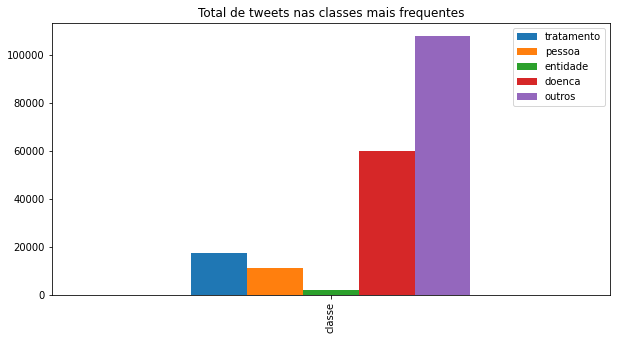

In [ ]:
# Exibindo um gráfico de barras dos totais de tweets por classe
classes = ['tratamento','pessoa','entidade','doenca','outros']

total_perguntas = duvidasDB.groupby(['classe'])['classe'].count()

show = pd.DataFrame([total_perguntas], columns=classes)
show.plot(kind= 'bar',figsize=(10,5),title='Total de tweets nas classes mais frequentes')

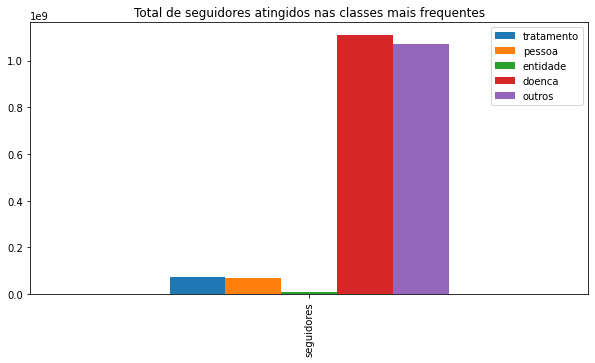

In [ ]:
# Exibindo um gráfico de barras dos totais de seguidores atingidos por classe
total_seguidores = duvidasDB.groupby(['classe'])['seguidores'].sum()

show = pd.DataFrame([total_seguidores], columns=classes)
show.plot(kind= 'bar',figsize=(10,5),title='Total de seguidores atingidos nas classes mais frequentes')

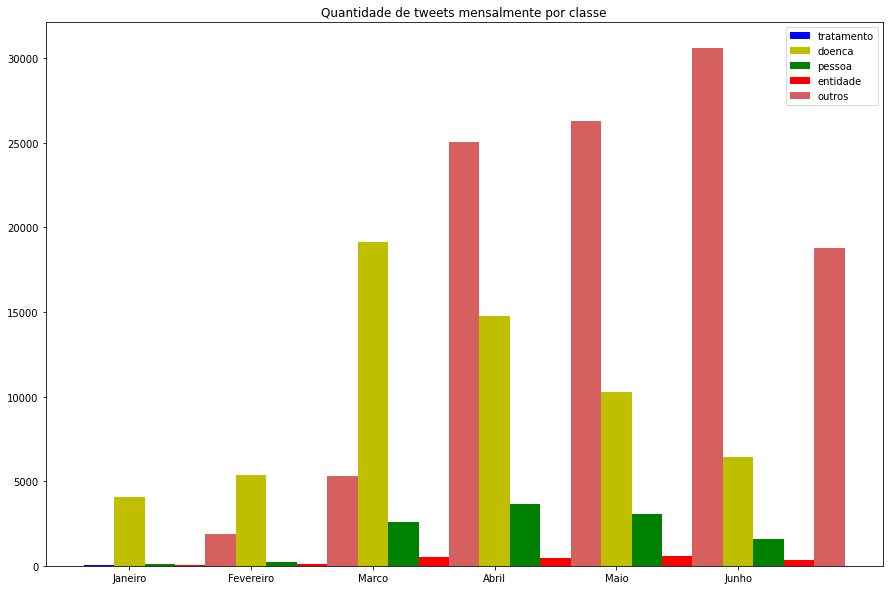

In [ ]:
from matplotlib import pyplot as plt
duvidasDB['data_inversa'] = pd.to_datetime(duvidasDB['data'],yearfirst=True, format='%Y-%m-%d')
# Agrupar os dados com base na nova coluna, criando um dataframe com os dados agrupados
dados_tratamento = duvidasDB[duvidasDB['classe'] == 'tratamento']
dados_tratamento = dados_tratamento['data_inversa'].groupby(dados_tratamento['data_inversa'].dt.to_period('M')).agg('count').to_frame()
dados_tratamento.columns = ['tratamento']

dados_doenca = duvidasDB[duvidasDB['classe'] == 'doenca']
dados_doenca = dados_doenca['data_inversa'].groupby(dados_doenca['data_inversa'].dt.to_period('M')).agg('count').to_frame()
dados_doenca.columns = ['doenca']

dados_pessoa = duvidasDB[duvidasDB['classe'] == 'pessoa']
dados_pessoa = dados_pessoa['data_inversa'].groupby(dados_pessoa['data_inversa'].dt.to_period('M')).agg('count').to_frame()
dados_pessoa.columns = ['pessoa']

dados_entidade = duvidasDB[duvidasDB['classe'] == 'entidade']
dados_entidade = dados_entidade['data_inversa'].groupby(dados_entidade['data_inversa'].dt.to_period('M')).agg('count').to_frame()
dados_entidade.columns = ['entidade']

dados_outros = duvidasDB[duvidasDB['classe'] == 'outros']
dados_outros = dados_outros['data_inversa'].groupby(dados_outros['data_inversa'].dt.to_period('M')).agg('count').to_frame()
dados_outros.columns = ['outros']

duvidasDB = duvidasDB.drop(columns=['data_inversa'])


# Cria eixo x para produto A e produto B com uma separação de 0.25 entre as barras
x1 =  np.arange(len(dados_tratamento))
x2 = [x + 0.25 for x in x1]
x3 = [x + 0.25 for x in x2]
x4 = [x + 0.25 for x in x3]
x5 = [x + 0.25 for x in x4]

# Plota as barras
plt.bar(x1, dados_tratamento['tratamento'], width=0.25, label = 'tratamento', color = 'b')
plt.bar(x2, dados_doenca['doenca'], width=0.25, label = 'doenca', color = 'y')
plt.bar(x3, dados_pessoa['pessoa'], width=0.25, label = 'pessoa', color = 'g')
plt.bar(x4, dados_entidade['entidade'], width=0.25, label = 'entidade', color = 'r')
plt.bar(x5, dados_outros['outros'], width=0.25, label = 'outros', color = '#d65f5f')

# Mostrar os primeiros registros do dataframe de valores agregados por dia
# plt.plot(dados_tratamento,color='red')
# plt.plot(dados_doenca,color='blue')

# coloca o nome dos meses como label do eixo x
meses = ['Janeiro','Fevereiro','Marco', 'Abril','Maio','Junho','Julho']
plt.xticks([x + 0.25 for x in range(len(dados_tratamento))], meses )

plt.rcParams['figure.figsize'] = (15,10)

# inseri uma legenda no gráfico
plt.legend()

plt.title("Quantidade de tweets mensalmente por classe")

plt.show()

Exibindo os dados georeferenciados

In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 3.4MB/s 
     |████████████████████████████████| 14.8MB 298kB/s 
     |████████████████████████████████| 10.9MB 18.9MB/s 


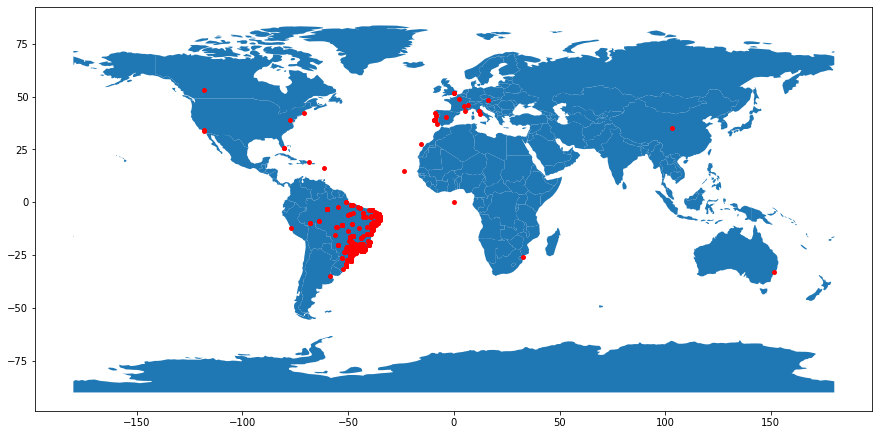

In [ ]:

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(duvidasDB['latitude'], duvidasDB['longitude'])]
gdf = GeoDataFrame(duvidasDB, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15, 9)), marker='o', color='red', markersize=15);

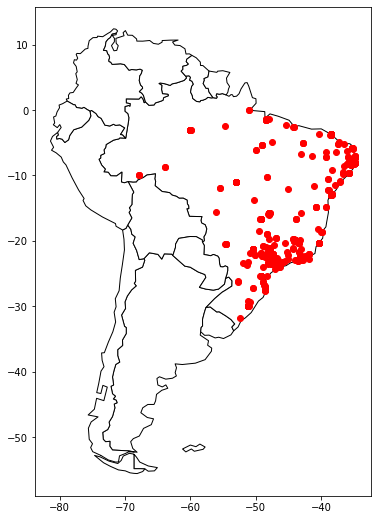

In [ ]:
# restringindo para o Brasil

duvidasDB_cidades = duvidasDB[duvidasDB['pais'] == 'Brazil']

geometry = [Point(xy) for xy in zip(duvidasDB_cidades['latitude'], duvidasDB_cidades['longitude'])]
gdf = GeoDataFrame(duvidasDB_cidades, geometry=geometry)   

ax = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black', figsize=(15,9))
gdf.plot(ax=ax, marker='o', color='red');

## 2.4 Frequência das palavras 

In [ ]:
dt = pd.read_csv('/content/drive/Shared drives/modulo02/duvidasDB_cleaned4.csv',index_col=0)
dt.columns = ['texto']
questions = list(dt.iloc[:,0])
all_questions = " ".join(questions)

In [ ]:
from nltk.probability import FreqDist

fdist = FreqDist([w.lower() for w in all_questions.split()])
for sentence in nltk.tokenize.sent_tokenize(all_questions):
  for word in nltk.tokenize.word_tokenize(sentence):
    fdist[word] += 1

result = []
for w in set(questions):
  if len(w) > 7 and fdist[w] > 200: #frequencia acima de 200
    result.append((w,fdist[w]))

result = sorted(result,key=lambda dist: dist[1],reverse=True)
print("tamanho=>{}".format(len(result)))
frequencia = list(fdist.most_common())
frequencia

tamanho=>198


[('coronavirus', 80088),
 ('quarentenar', 30676),
 ('pandemia', 30598),
 ('ir', 30242),
 ('cloroquina', 25755),
 ('fazer', 21734),
 ('social', 20911),
 ('virus', 19300),
 ('isolamento', 17130),
 ('saber', 15632),
 ('poder', 14644),
 ('querer', 13936),
 ('algum', 12924),
 ('gente', 10988),
 ('covid', 10525),
 ('ser', 10361),
 ('ficar', 10136),
 ('dia', 9848),
 ('usar', 9392),
 ('pessoa', 9382),
 ('agora', 8946),
 ('casar', 8934),
 ('ver', 8585),
 ('dizer', 8329),
 ('tomar', 8326),
 ('esto', 8279),
 ('falar', 8247),
 ('sobrar', 8144),
 ('achar', 8098),
 ('todo', 7938),
 ('vocs', 7711),
 ('hidroxicloroquina', 7583),
 ('brasil', 7548),
 ('ter', 6894),
 ('acabar', 6614),
 ('bolsonaro', 6587),
 ('morrer', 6478),
 ('dar', 5862),
 ('lockdown', 5809),
 ('onde', 5745),
 ('ainda', 5576),
 ('mundo', 5533),
 ('so', 5379),
 ('pegar', 5016),
 ('mear', 5012),
 ('porque', 5003),
 ('distanciamento', 4981),
 ('tudo', 4853),
 ('cad', 4852),
 ('contra', 4810),
 ('curar', 4806),
 ('passar', 4687),
 ('dessar

In [ ]:
words= [ x[0] for x in frequencia[0:10]]
freq =[ x[1] for x in frequencia[0:10]]

df = pd.DataFrame(freq,index=words)
print(df)

                 0
coronavirus  80088
quarentenar  30676
pandemia     30598
ir           30242
cloroquina   25755
fazer        21734
social       20911
virus        19300
isolamento   17130
saber        15632


In [ ]:
import nltk.corpus  
from nltk.text import Text  
from nltk.tokenize import sent_tokenize, word_tokenize

## 2.5 Classificação criada com base no banco lematizado

In [ ]:
# pip install nltk

import nltk

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
# from nltk import sent_tokenize

from nltk.corpus import stopwords
from string import punctuation

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('mac_morpho')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package mac_morpho to /root/nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!


True

In [ ]:
# segunda forma de classificação usando uma lista de palavras chaves lematizadas

# if que verifica se já existe arquivo de dúvidas classificadas. Se  existir o arquivo é lido
if os.path.exists('/content/drive/Shared drives/modulo02/duvidasDB-classificadas-2.csv'):
   duvidasDB_clean = pd.read_csv('/content/drive/Shared drives/modulo02/duvidasDB-classificadas-2.csv')

# se não existir, ele é criado.
else :
   # Seleciona palavras chaves para a seleção do grupo da pergunta
   tratamento  = ['vacinar', 'tomar', 'toma', 'tomam', 'tomou', 'tomaram', 'receitar', 'receita', 'receitam', 'receitou', 'receitaram', 'beber', 'bebe', 'bebem', 'bebeu', 'beberam', 'tamiflu', 'cloroquina', 'hidroxicloroquina', 'azitromicina', 'ivermectina']
   pessoa      = ['ministrar', 'governar','governador', 'prefeito', 'presidente', 'secretario', 'senador', 'senadora' ,'deputado', 'vereador', 'senhor', 'senhora', 'sr', 'sra', 'bolsonaro', 'bolzonaro', 'bozo', 'dória', 'doria', 'wilson', 'witzel', 'jairbolsonaro', 'lula', 'mandeta', 'mandetta', 'moro', 'teich', 'pazuello', 'pazuelo']
   entidade    = ['governo', 'prefeitura', 'secretaria', 'empresa', 'stf', 'globo', 'record', 'tribunal', 'oms']
   doenca      = ['pandemia', 'coronavrus', 'coronavírus', 'covid', 'covid19', 'coronavirus', 'covid-19', 'sars-cov-2', 'corona', 'gripe', 'pandamia', 'virus']

   # recuperando o DataFrame
   # if duvidasDB_clean is None :
   duvidasDB_clean = pd.read_csv('/content/drive/Shared drives/modulo02/duvidasDB_cleaned4.csv')

   #Selecionando as palavras a serem descartadas
   stopwords = set(stopwords.words('portuguese') + list(punctuation))

   j = 0

   for index, row in duvidasDB_clean.iterrows():

       # extrai o texto contendo a pergunta
       texto = duvidasDB_clean.loc[index,'0']
       # converte tudo em minusculo
       texto = texto.lower()
       # tokeniza o texto
       palavras = word_tokenize(texto,)  
       # gera o texto sem as palavras tidas como menos relevantes
       palavras_sem_stopwords = [palavra for palavra in palavras if palavra not in stopwords]
 
       # Classe geral 
       classe = 'outros'
       # 1: Esta classificação é feita com base na presença de determinadas palavras numa pergunta. Aqui adota-se uma classificação única para a pergunta.
       # Adota-se como critério a idéia de que a presença de determinados elementos induz a classificação da pergunta por
       # ser mais específico. Assim, se um elemento está presente, ele define a classificação da pergunta.
       # Assumimos que a classe pessoa é a mais especifica. A presença de pessoa induz a pergunta a ser classificada como referente à pessoa.
       # Em seguida, entidade/organizacao é a mais específica, sendo a próxima a definir uma classe de pergunta.
       # A terceira é o tratamento. Por fim, o caso mais geral é o de presença da palavra que induz a classificaçao com sendo referente à doença.

       for pal in palavras_sem_stopwords:
         if pal in pessoa:
           classe = 'pessoa'
           break

         if pal in entidade:
           classe = 'entidade'
           break

         if pal in tratamento:
           classe = 'tratamento'
           break

         if pal in doenca:
           classe = 'doenca'
           break
    
       duvidasDB_clean.loc[index,'classe'] = classe

   duvidasDB_clean.to_csv('/content/drive/Shared drives/modulo02/duvidasDB-classificadas-2.csv')
# Fim do if  

Exibindo um Gráfico de Barras comparando os totais de tweets das diversas classes de perguntas


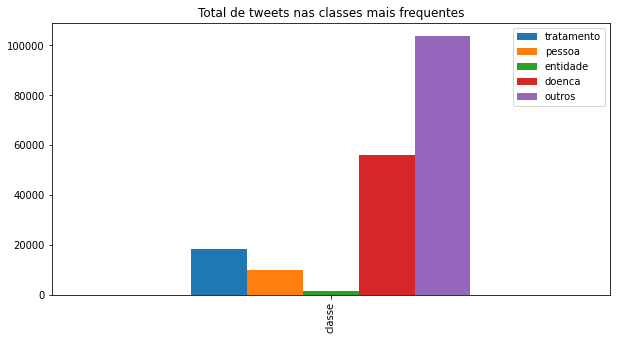

In [ ]:
# Exibindo um gráfico de barras dos totais de tweets por classe
classes = ['tratamento','pessoa','entidade','doenca','outros']

total_perguntas = duvidasDB_clean.groupby(['classe'])['classe'].count()

show = pd.DataFrame([total_perguntas], columns=classes)
show.plot(kind= 'bar',figsize=(10,5),title='Total de tweets nas classes mais frequentes')

## 2.6 Análise das categorias


### 2.6.1 Doença

In [ ]:
dt = pd.read_csv('/content/drive/Shared drives/modulo02/duvidasDB_cleaned4.csv',index_col=0)
dt.columns = ['texto']
questions = list(dt.iloc[:,0])
all_questions = " ".join(questions)

In [ ]:
tokens = word_tokenize(all_questions, language='portuguese')
texts2= Text(tokens)
texts2.common_contexts(['doena','virus'])

coronavirus_causar dessar_dar contra_cloroquina virus_fazer
coronavirus_vc coronavirus_absolutamente coronavirus_mundial
outro_cervejar pegar_at social_ir novo_coronavirus tratar_j
coronavirus_x achar_brincadeira coronavirus_criar coronavirus_beber
causar_coronavirus outro_coronavirus coronavirus_matar
coronavirus_provocar


In [ ]:
tokens = word_tokenize(all_questions, language='portuguese')
texts2= Text(tokens)
texts2.similar('coronavirus')

pandemia covid quarentenar ir cloroquina gente fazer saber virus poder
ser querer algum agora covi brasil dia pessoa acabar bolsonaro


In [ ]:
tokens = word_tokenize(all_questions, language='portuguese')
texts2= Text(tokens)
texts2.similar('gripezinha')

cloroquina coronavirus hidroxicloroquina pandemia ir usar ser curar
vacinar achar quarentenar fazer saber pessoa tomar poder querer algum
porque tratamento


In [ ]:
tokens = word_tokenize(all_questions, language='portuguese')
texts2= Text(tokens)
texts2.similar('saude')

coronavirus ir cloroquina pandemia fazer poder agora quarentenar
querer dia gente saber hidroxicloroquina sobrar ficar casar mandetta
vocs porque pessoa



*   As informações posicionais podem ser exibidas usando um gráfico de dispersão. 
*   Cada faixa representa uma instância de uma palavra e cada linha representa texto inteiro.

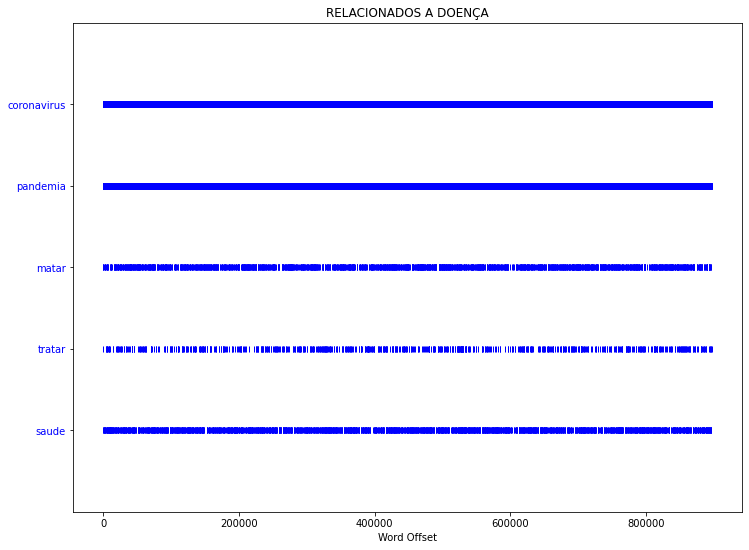

In [ ]:
from nltk.draw.dispersion import dispersion_plot
import matplotlib.pyplot as plt

tokens = word_tokenize(all_questions, language='portuguese')
texts = Text(tokens)

plt.figure(figsize=(12, 9))
targets=["coronavirus", "pandemia","matar","tratar","saude"]
dispersion_plot(texts, targets, ignore_case=True, title='RELACIONADOS A DOENÇA')

### 2.6.2 Medicamento

In [ ]:
tokens = word_tokenize(all_questions, language='portuguese')
texts2= Text(tokens)
texts2.similar('medicamentar')

cloroquina coronavirus hidroxicloroquina usar pandemia tratamento ser
covid remédio ir virus quarentenar tomar vacinar ivermectina tal algum
dizer poder querer


In [ ]:
tokens = word_tokenize(all_questions, language='portuguese')
texts2= Text(tokens)
texts2.similar('remédio')

cloroquina coronavirus hidroxicloroquina pandemia ir usar ser curar
vacinar achar quarentenar fazer saber pessoa tomar poder querer algum
porque tratamento


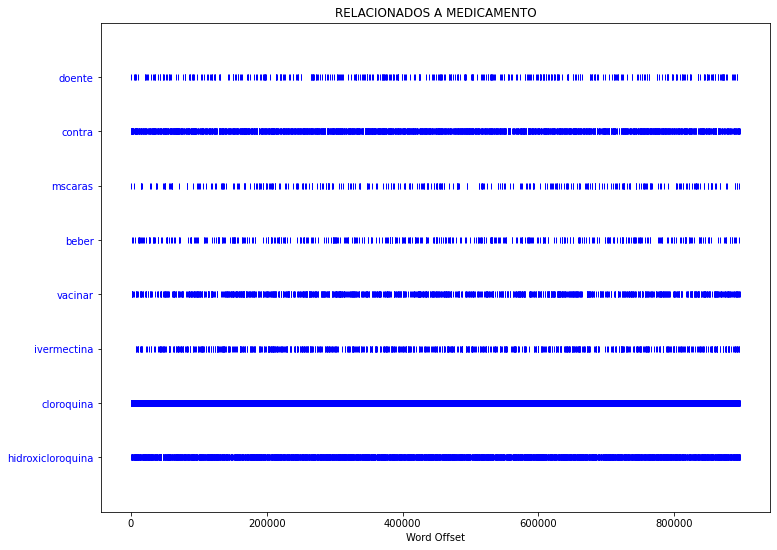

In [ ]:
tokens = word_tokenize(all_questions, language='portuguese')
texts = Text(tokens)

plt.figure(figsize=(12, 9))
targets=["doente","contra","mscaras","beber","vacinar","ivermectina","cloroquina","hidroxicloroquina"]
dispersion_plot(texts, targets, ignore_case=True, title='RELACIONADOS A MEDICAMENTO')


# tokens = word_tokenize(all_questions, language='portuguese')
# texts = Text(tokens)
# texts.dispersion_plot(["doente","contra","mscaras","beber","vacinar","ivermectina","cloroquina","hidroxicloroquina"])

### 2.6.3 Organizações

Comparando a localização das dúvidas referentes a Organizações/Entidades e Pessoas

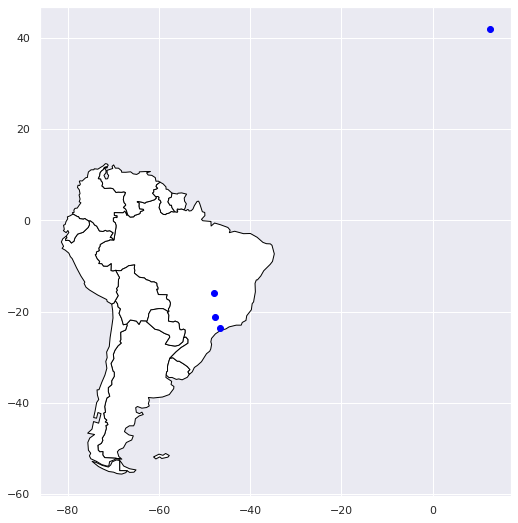

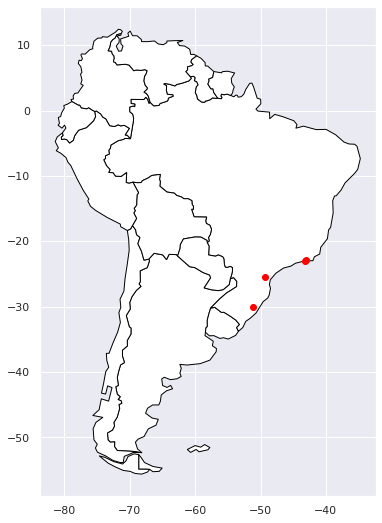

In [ ]:
# restringindo para o Brasil

duvidasDB_cidades = duvidasDB[duvidasDB['pais'] == 'Brazil']

duvidasDB_cidades = duvidasDB[duvidasDB['classe'] == 'pessoa']

geometry = [Point(xy) for xy in zip(duvidasDB_cidades['latitude'], duvidasDB_cidades['longitude'])]
gdf = GeoDataFrame(duvidasDB_cidades, geometry=geometry)   

ax = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black', figsize=(15,9))

gdf.plot(ax=ax, marker='o', color='blue');

duvidasDB_cidades = duvidasDB[duvidasDB['pais'] == 'Brazil']

duvidasDB_cidades = duvidasDB[duvidasDB['classe'] == 'entidade']

geometry = [Point(xy) for xy in zip(duvidasDB_cidades['latitude'], duvidasDB_cidades['longitude'])]
gdf = GeoDataFrame(duvidasDB_cidades, geometry=geometry)   

ax = world[world.continent == 'South America'].plot(
    color='white', edgecolor='black', figsize=(15,9))


gdf.plot(ax=ax, marker='o', color='red');

Listando a quantidade de perguntas envolvendo entidades que foram consideradas

In [ ]:

duvidasDB_cidades.count

/usr/local/lib/python3.6/dist-packages/geopandas/array.py:689: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/usr/local/lib/python3.6/dist-packages/geopandas/array.py:690: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/usr/local/lib/python3.6/dist-packages/geopandas/array.py:691: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/usr/local/lib/python3.6/dist-packages/geopandas/array.py:692: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy


<bound method DataFrame.count of         Unnamed: 0  Unnamed: 0.1  ...    classe         geometry
83              83             0  ...  entidade  POINT (nan nan)
295            295             0  ...  entidade  POINT (nan nan)
413            413             0  ...  entidade  POINT (nan nan)
539            539             0  ...  entidade  POINT (nan nan)
576            576             0  ...  entidade  POINT (nan nan)
...            ...           ...  ...       ...              ...
197930      197930             0  ...  entidade  POINT (nan nan)
198005      198005             0  ...  entidade  POINT (nan nan)
198006      198006             0  ...  entidade  POINT (nan nan)
198086      198086             0  ...  entidade  POINT (nan nan)
198089      198089             0  ...  entidade  POINT (nan nan)

[2009 rows x 15 columns]>

Listando algumas das perguntas envolvendo entidades que foram consideradas

In [ ]:
duvidasDB_cidades.head(-10 )

/usr/local/lib/python3.6/dist-packages/geopandas/array.py:689: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/usr/local/lib/python3.6/dist-packages/geopandas/array.py:690: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/usr/local/lib/python3.6/dist-packages/geopandas/array.py:691: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/usr/local/lib/python3.6/dist-packages/geopandas/array.py:692: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy
/usr/local/lib/python3.6/dist-packages/geopandas/array.py:689: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/usr/local/lib/python3.6/dist-packages/geopandas/array.py:690: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/usr/local/lib/python3.6/dist-packages/geopandas/array.py:691: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/usr/local/lib/python3.6/dist-packages/geopandas/array.

,Unnamed: 0,Unnamed: 0.1,data,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,pergunta,id_origem,classe,geometry
83,83,0,2020-03-26 21:53:27,0,1050,pt,NaN,NaN,NaN,NaN,NaN,O que governo faz para melhorar isso?,670,entidade,POINT (nan nan)
295,295,0,2020-03-10 19:48:18,0,2099,pt,NaN,NaN,NaN,NaN,NaN,A estratégia do governo é vacinar o que dá pra...,2384,entidade,POINT (nan nan)
413,413,0,2020-04-13 23:25:48,1,461,pt,NaN,NaN,NaN,NaN,NaN,"Nós , esquerdistas, que torcemos contra o gov...",3299,entidade,POINT (nan nan)
539,539,0,2020-03-30 23:15:03,0,700,pt,NaN,NaN,NaN,NaN,NaN,"@jdoriajr @governosp @jdoriajr, o governo do e...",4396,entidade,POINT (nan nan)
576,576,0,2020-03-26 14:47:11,0,36,pt,NaN,NaN,NaN,NaN,NaN,@wilsonwitzel @jornaldacbn @CBNoficial Há seu ...,4665,entidade,POINT (nan nan)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196580,196580,0,2020-04-07 17:26:17,0,28,pt,NaN,NaN,NaN,NaN,NaN,Na Globo?,1645590,entidade,POINT (nan nan)
196691,196691,0,2020-03-26 23:40:48,0,1769,pt,NaN,NaN,NaN,NaN,NaN,#JN o governo está fazendo lambança com dengue...,1646555,entidade,POINT (nan nan)
196839,196839,0,2020-01-31 23:31:33,0,242,pt,NaN,NaN,NaN,NaN,NaN,@lucasrohan Eles de quarentena e você querendo...,1647618,entidade,POINT (nan nan)
196905,196905,0,2020-05-24 12:49:32,0,823,pt,NaN,NaN,NaN,NaN,NaN,@Estadao @slpng_giants_pt Lutar contra fake ne...,1648096,entidade,POINT (nan nan)


### 2.6.4 Pessoas

Exibindo um comparativo das quantidades de tweets referentes a Pessoas e Entidades ao longo dos dias do ano de 2020

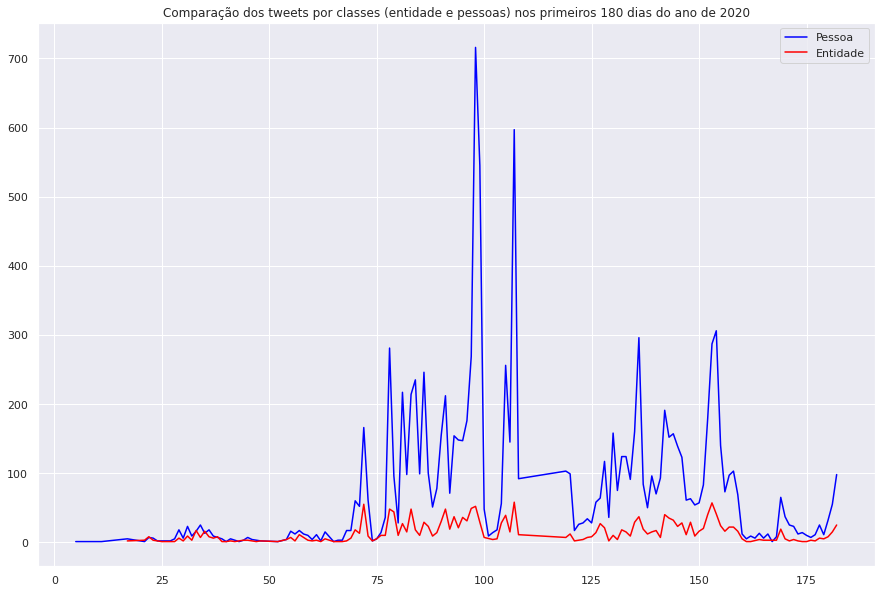

In [ ]:
from matplotlib import pyplot as plt
duvidasDB['data_inversa'] = pd.to_datetime(duvidasDB['data'],yearfirst=True, format='%Y-%m-%d')
# Agrupar os dados com base na nova coluna, criando um dataframe com os dados agrupados

dados_pessoa = duvidasDB[duvidasDB['classe'] == 'pessoa']
dados_pessoa = dados_pessoa['data_inversa'].groupby(dados_pessoa['data_inversa'].dt.to_period('D')).agg('count').to_frame()
dados_pessoa.columns = ['pessoa']

dados_entidade = duvidasDB[duvidasDB['classe'] == 'entidade']
dados_entidade = dados_entidade['data_inversa'].groupby(dados_entidade['data_inversa'].dt.to_period('D')).agg('count').to_frame()
dados_entidade.columns = ['entidade']

duvidasDB = duvidasDB.drop(columns=['data_inversa'])

# Mostrar os primeiros registros do dataframe de valores agregados por dia

fig, ax = plt.subplots()
ax.plot(dados_pessoa.index.dayofyear, dados_pessoa['pessoa'] , color="blue",scaley=True , label='Pessoa')
ax.plot(dados_entidade.index.dayofyear, dados_entidade['entidade'] , color="red",scaley=True, label='Entidade')

plt.rcParams['figure.figsize'] = (15,10)

# inseri uma legenda no gráfico
plt.legend()
plt.title("Comparação dos tweets por classes (entidade e pessoas) nos primeiros 180 dias do ano de 2020")

plt.show()

# 3 - Conclusões